# 训练模型

当目前为止，不同的机器学习模型，也就是算法问题，更应该注重的是算法怎么训练！！！

例如，sklearn 里面好多的训练算法都是一个黑匣子，可以一无所知就实现算法的训练

很好的理解算法时如何训练的是很有必要的，而且是有帮助的
- 有助于快速定位到合适的模型
- 有助于快速定于到正确的训练算法
- 有助于快速定位到一套合适的超参数
- 有助于后期更高效地执行错误调试和错误分析

线性回归模型的两种不同的训练模型方法
- 通过 “ 闭式 ” 方程 —— 直接计算出最合适训练集的模型参数（损失函数最小化）
- 使用迭代优化方法，即梯度下降（GD），逐渐调整模型参数直至训练集上的成本函数调制最低，最终趋同于计算出来的模型参数
    - 批量梯度下降 Batch gradient descent, BGD
    - 小批量梯度下降 Mini-batch gradient descent, SBGD
    - 随机梯度下降 Stochastic gradient descent, SGD
    
多项式回归，适合非线性数据集，由于模型的参数多，因此容易造成对训练数据过拟合
- 使用学习曲线来分辨过拟合是否发生
- 正则化技巧，降低过度拟合训练数据的风险

两种常用于分类任务的模型
- Logistic 回归
- Softmax 回归


# 线性回归

![self](./image/linear1.png)
![self](./image/linear2.png)
![self](./image/linear3.png)
![self](./image/linear4.png)

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
   

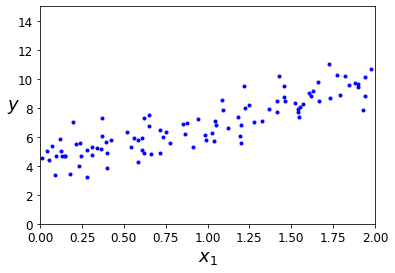

In [2]:
# 生成一些线性数据测试公式
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()


In [3]:
# 使用标准方程计算 θ 
# 使用 numpy 线性代数模块（np.linalg）中 inv() 函数对矩阵求逆，并用 dot() 方法计算矩阵内积
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

theta_best

array([[4.21509616],
       [2.77011339]])

In [4]:
# 实际期待的结果由于高斯噪声的存在，故此有所差异
# 现在使用 theta_best 进行预测
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

y_predict

array([[4.21509616],
       [9.75532293]])

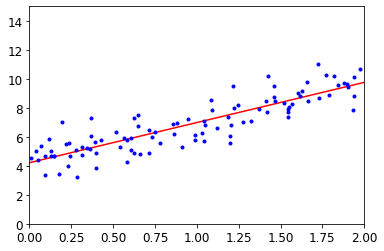

In [5]:
# 可视化模型预测结果
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

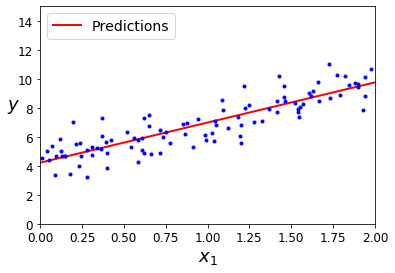

In [6]:
# 可视化调整
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
# 使用 sklearn 实现相同功能的代码如下
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

### sklearn 实现的结果 和 自己计算的结果完全一致

# 计算复杂度
- 标准方程求逆的矩阵 X.T.dot(X)，是一个 n*n 矩阵（n为特征数量）
- 这种矩阵求逆计算时间复杂度通常为 O(n^2.4) 到 O(n^3) ，具体取决于计算实现（算法导论中有解释）
- 如果将特征数量 n 翻倍，那时间复杂度将乘以大约 2^2.4=5.3 倍 到 2^3=8 倍之间
- 特征数量特别大，标准方程计算将极其缓慢，时间复杂度不佳
- 解决特征数量大，或者内存无法满足的时候，选择其他训练方法，如梯度下降


# 梯度下降
- 梯度下降时最优化理论里最基础的方法，是一种非常通用的优化算法，能够为大范围的问题寻找到最优解
- 梯度下降的中心思想就是迭代地调整参数从而是成本函数最小化
- 通过测量参数向量 θ 相关的误差函数的局部梯度，并不断沿着降低梯度的方向调整，直到梯度降为 0，达到最小值
- 具体来说，首先使用一个随机的 θ 值（随机初始化），然后逐步改进，每次踏出一步，都尝试降低成本函数（如MSE,RMSE），直到算法收敛出一个最小值
- 梯度下降最重要参数是每一步的步长，取决于超参数-学习率
- 学习率太低，算法需要经过大量迭代才能收敛，耗费时间
- 学习率太高，可能越过山谷直接到达山的另一边，甚至可能比之前起点还高，导致算法发散，值越来越大，形成震荡，无法找到解决方案
- 并不是所有的成本函数看起来都是一个漂亮的碗，有可能是像洞、山脉、高原或者其他不规则地形，导致很难收敛到最小值
- 梯度下降挑战：随机初始化，算法从左侧起步，那么会收敛到一个局部最小值，而不是全局最小值；算法从右侧起步，那么需要经过很长时间才能越过整片高原，如果停下太早，将永远达不到全局最小值
- 线性回归模型的 MSE 成本函数是一个凸函数，这意味着连接曲线上任意两个点的线段永远不会跟曲线相交，也就是只有全局最小，没有局部最小；同时也是一个连续函数，所以斜率不会产生陡峭变化
- 凸函数保证的结论：梯度下降一定获得全局最小值，只需要等待时间足够长，学习率不是太高
- 成本函数虽然是碗状的，但是如果不同特征的尺寸差距巨大，那它可能是一个非常细长的碗，碗的形状会影响梯度下降
- 应用梯度下降时，需要保证所有特征值的大小比例都差不多（standardScaler），否则收敛的时间会很长
- 训练模型就是搜素使得成本函数最小化的参数组合，这是模型参数空间层面上的搜索：模型的参数越多，这个空间的维度就越多，搜索就越难

![self](./image/gd1.png)
![self](./image/gd2.png)
![self](./image/gd3.png)
![self](./image/gd4.png)
![self](./image/gd5.png)


# 批量梯度下降 batch gradient descent
- 要实现梯度下降，需要计算每个模型关于参数 θ 的成本函数
- 需要计算的是改变 θ ，成本函数会改变多少，即就是求解偏导数
- 不想单独计算这个梯度，可以使用公式进行一次性计算，梯度向量化
- 计算梯度下降的每一个步都是基于完整的训练集数据，故此称之为批量梯度下降
- 面对庞大嘚瑟训练集数据时，算法会变得极慢，但是梯度下降算法随着特征数量扩展的表现较好，比标准方程快得多
- 一旦有了梯度向量，那个点向上，就朝其反方向下降即可
- 学习率 Eata 计算出来了，用梯度向量乘以学习率就可以得出下降的步长大小

![self](./image/bgd1.png)
![self](./image/bgd2.png)
![self](./image/bgd3.png)


In [11]:
# 实现 BGD 算法
# learning rate
eta = 0.1
# 迭代次数
n_iterations = 1000
# 特征数量
m = 100

# random initialization the theta hyper-parameter
theta = np.random.randn(2, 1)

# 开始迭代
for iteration in range(n_iterations):
    # 计算梯度向量
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    # 更新梯度
    theta = theta - eta * gradients
    

In [12]:
# 查看结果 theta
theta

array([[4.21509616],
       [2.77011339]])

In [13]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

结果与标准方程的结果一致性，证明梯度下降表现完美


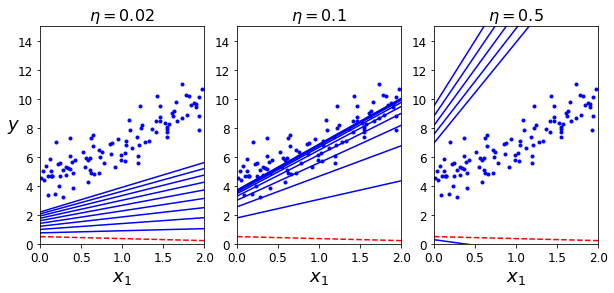

In [14]:
# 使用不同的学习率 eta 进行梯度下降的前十步，虚线表示起点
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

可视化结果显示
- 左边可视化可知，由于学习率太低，算法最终还是能找到解决方法，就是需要时间太长
- 中间可视化可知，经过几次迭代就收敛到最终解，表现非常棒
- 右边可视化可知，由于学习率太高，算法发散，直接跳过数据区域，并且每一个都距离实际解决方案越来越远

寻找到合适的学习率，可以使用 网格搜索 方法，但是需要限制迭代次数，这样网格搜索才可以淘汰那些收敛耗时太长的模型
- 怎么限制迭代次数？
- 设置太低，算法可能在距离最优解还很远时就停了
- 设置太高，模型达到最优解后，继续迭代参数不在变化，浪费时间
- solution：开始时设置一个非常大的迭代次数，但是当梯度向量的值变得很微小时中断算法 —— 也即是当它的范数变得低于 epic （容差），因为此时梯度已经下降到最小值
- 收敛率：成本函数为凸函数，并且斜率没有陡峭变换（连续函数）时，通过批量梯度下降可以知道一个固定的学习率有一个收敛率，为 1 / 迭代次数
- 收敛率：如果将容差 epic 缩小到原来的 1 / 10 ，算法将不得不运行 10 倍的迭代次数


# 随机梯度下降 stochastic gradient descent
- 批量梯度下降主要问题就是要用到整个训练集来计算每一步的梯度，训练集很大时，算法会很慢
- 随机梯度下降，每一步在训练集中随机选择一个实例，并且仅基于该单个实例来计算梯度，显然算法变得快很多
- 也可以用来训练海量的数据集，因为每次迭代只需要在内存中运行一个实例即可（SGD可以作为核外算法实现）
- 由于算法的随机性质，比批量梯度下降要不规则得多，成本函数将不再是缓缓降低至最小值，而是不断上上下下，但从整体来说，还是慢慢下降
- 随着时间推移，最终会非常接近最小值，但是即使达到最小值，依旧还会持续反弹，永远不会停止，所以算法停下来的参数值肯定是足够好的，但不是最优的
- 当成本函数是不规则时，随机梯度下降可以帮助算法跳出局部最小值，相比较与批量梯度下降，随机梯度下降对找到全局最小值更有优势
- 随机性的好处就是可以逃离局部最优，缺点是永远无法定位到最小值
- 解决这个问题，逐步降低学习率：开始步长比较大，有助于快速进展和逃离局部最小值，然后越来越小，让算法接近全局最小值，这个过程称之为 模拟退火
- 因为类似于冶金时熔化的金属慢慢冷却的退火过程
- 确定每个迭代学习率的函数叫做学习计划。学习率降得太快，可能陷入局部最小值，甚至停留在走向最小值的半途中；学习率降得太慢，需要太长时间才能跳到差不多最小值附近，如果提早结束训练，可能只得到一个次优的解决方案

![self](./image/sgd1.png)

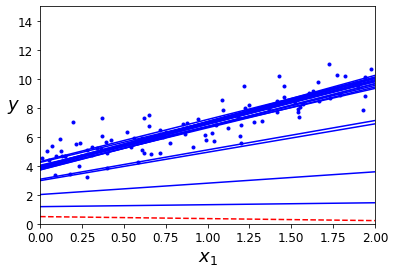

In [16]:
# 实现一个简单的学习计划实现随机梯度下降
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50

# learning schedule hyperparameters
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

# random initialization the theta hyperparameters
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        # 可视化过程
        if epoch == 0 and i < 20:             
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        # 获取每一次迭代的实例数据
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        # 梯度计算
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        # 改变学习率
        eta = learning_schedule(epoch * m + i)
        # 更新梯度
        theta = theta - eta * gradients
        # 将梯度放入列表，可视化
        theta_path_sgd.append(theta)
        
        
plt.plot(X, y, "b.")                      
plt.xlabel("$x_1$", fontsize=18)          
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])                   
plt.show()                                

In [17]:
theta

array([[4.21076011],
       [2.74856079]])

惯例而言，使用 m 表示迭代次数，每次迭代称之为一轮

前面批量梯度下降需要 1000 次，而随机梯度下降只需要 50 次就得到一个相当不错的解

上图显示训练过程的前 10 步，注意不规则的步子

因为实例是随机挑选的，所以在同一轮里面某些实例可能被挑选了多次，而有些实例完全被挑选

想要每一轮算法都能遍历每一个实例，solution 是将训练集洗牌打乱，然后一个一个的使用实例，用完之后在重新洗牌，一次继续，这样通常收敛得更慢

sklearn 里面，使用 SGD 执行线性回归可以使用 SGDRegressor 类，其默认优化的成本函数是平方误差

In [20]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=50,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [21]:
# 再一次得到跟标准方程的解非常相近的解决方案
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

# 小批量梯度下降 Mini-batch gradient descent
- 每一步的梯度计算，既不是基于整个训练集（批量梯度下降）也不是基于单个实例（随机梯度下降），而是基于一小部分随机的实例集也就是小批量
- 相比于随机梯度下降，小批量梯度下降的主要优势在于可以从矩阵运算的硬件优化中获得显著的性能提升，特别是需要用到图形处理器（如GPU）
- 该算法在参数空间层面的前进过程不像 SGD 那样不稳定，特别是批量较大时，所有小批量梯度下降最终回比 SGD 更接近最小值一些
- 但是另一方面，可能更难从局部最小值中逃脱，特别是哪些深受局部最小值陷阱的问题
- 下图显示三种梯度下降算法在训练过程中参数空间里面的行进路线，最终都会汇聚最小值附近
- 批量梯度下降最终停留在最小值上，随机梯度下降和小批量梯度下降还在继续游走，不过批量梯度下降花费了大量时间计算每一步；应用好学习计划，SGD \ MBGD 同样达到相同的效果


In [22]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 10, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
        

In [23]:
theta

array([[4.25214635],
       [2.7896408 ]])

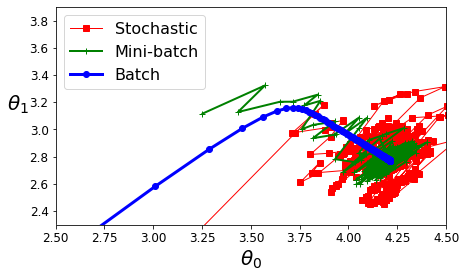

In [24]:
# 可视化三种随机梯度下降 在参数空间的行进过程
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

比较线性回归算法，m 是训练实例的数量，n 是特征数量

![self](./image/xxhg.png)

# 多项式回归 Polynomial regression
- 数据比简单的直线复杂，其实可以用线性模型来拟合非线性数据
- solution：将每个特征的幂次方添加一个新特性，然后在这个拓展过的特征集上训练线性模型，这个方法称之为多项式回归
- 基于简单的二次方程制造非线性数据，添加随机噪声


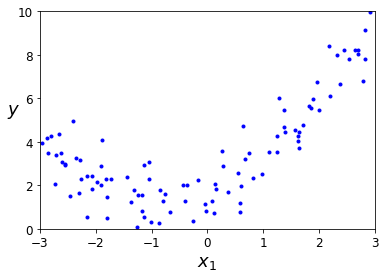

In [26]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)


m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

# 可视化数据
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

显然，直线是无法拟合这个数据

使用 sklearn 的 PolynomialFeatures 类来对训练数据进行转换，将每个特征的二次方（二次多项式）最为新特征加入训练集


In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [28]:
X_poly[0]

array([-0.75275929,  0.56664654])

X_poly 包含原来的特征X 和该特征的平方

对这个扩展后训练集匹配一个 线性回归模型


In [29]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

得到的线性模型预测：y_ = 0.56 * x^2 + 0.93 * x + 1.78

原始数据模型：y = 0.5 * x^2 + 1.0 *x + 2 + 高斯噪声

所以看起来还不错，可视化这个拟合过程


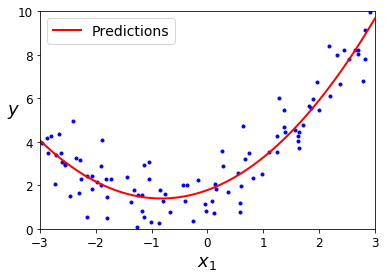

In [30]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

noting:
- 当存在多个特征时， 多项式回归能够发现特征之间的关系，因为 PolynomialFeatures 会在给定的多项式阶数下，添加所有特征的组合
- 纯线性回归模型是做不到这一点的
- 例如，有两个特征 a 和 b， 阶数 degree=3 ，PolynomialFeatures 不会只添加特征 a^2, a^3, b^2, b^3, 还会添加组合 ab，a^2b, ab^2
- PolynomialFeatures(degree=d) 可以将一个包含 n 特征的数组转换为包含 （n+d）/ (d! n!) 个特征的数组，由于阶乘的存在，要注意特征组合的数量爆炸


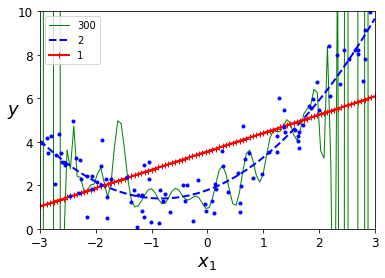

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

# 学习曲线
- 高阶多项式回归对训练数据的拟合，很有可能比简单线性回归要好
- 以上可视化过程可知，300阶模型以波动的形式拟合训练实例，对比纯线性模型和二次模型
- 当然，高阶多项式回归模型容易严重过度拟合训练数据，线性模型则是拟合不足，二次模型泛化能力最好
- 这个结论很合理，因为原始数据就是二次函数产生的
- 那么在不知道数据产生的数学函数模型，如何确定模型的复杂程度呢？怎么判断模型的过拟合和欠拟合？
- solution
    - 使用交叉验证评估模型的泛化性能。训练集表现良好，交叉验证的泛化表现非常糟糕，则是模型过度拟合；两者表现都不佳，就是拟合不足
    - 观察学习曲线，这个曲线绘制的是模型在训练集和验证集上，关于“训练集大小”的性能函数，要生成这个曲线，只需要在不同大小的训练子集上多次训练模型即可
    - 这段代码，在给定训练集上定义函数，绘制模型的学习曲线
    

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

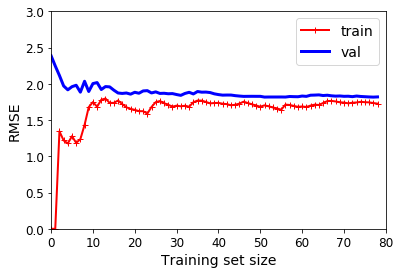

In [36]:
# 看一看纯线性回归模型的学习曲线
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.show()                                      # not shown

学习曲线
- 首先，训练数据上的性能，训练集中只包含一两个实例时，模型可以完美拟合，故此曲线从 0 开始，
- 但是随着新的实例被添加进训练集中，模型不再能完美拟合训练数据，因为数据由噪声，并且根本不是线性的，所以训练集误差上升，直达一个高地
- 在制高点，添加新实例到训练集不在是平均误差上升或者下降
- 然后，验证集数据集性能，当训练集实例非常少，模型不能很好泛化，故此验证集误差值一开始非常大，随着模型经历更多的训练数据，开始学习，验证集误差下降
- 但是仅靠一条直线不能很好的为数据建模，所以误差也停留在一个高值，跟另一条曲线十分接近
- 这个可视化的学习曲线，就是典型的模型拟合不足，两条线均达到高地，非常接近，而且相当高
- 如果模型对训练数据拟合不足，添加更多的训练实例也无事于补，需要使用更加复杂的模型或者找到更好的特征


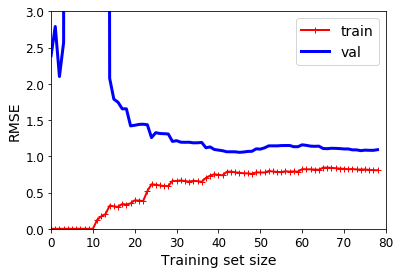

In [37]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
plt.show()                        # not shown

学习曲线
- 这个是在同样的数据集上，一个 10 阶多项式模型的学习曲线
- 看起来跟线性模型差不多，但是有两个非常重大的区别
    - 训练数据的误差远低于线性回归模型
    - 两个曲线之间有一定的差距，意味着该模型在训练数据上表现比验证集要好，这正是过拟合的标志，使用更大的训练集，那么两条曲线将会越来越接近
    - 改进模型过拟合的方法之一，提供更多的训练数据，直到验证误差接近训练误差
    
    
偏差/方差 权衡
- 在统计学和机器学习领域，重要结论是，模型的泛化误差可以被表示为三个截然不同的误差之和
- 偏差
    - 这部分泛化误差的原因在于错误的假设，比如假设数据是线性的，而实际是二次的
    - 高偏差模型最有可能对训练数据拟合不足
- 方差
    - 这部分误差是由于模型对训练数据的微小变换过的敏感导致
    - 具有高自由度的模型（如高阶多项式模型）很可能也有高方差，所以容易对训练数据多度拟合
- 不可避免的误差
    - 这部分误差是因为数据本身的噪声所致
    - 减少这部分误差的唯一方法就是清理数据（如修复数据源、损坏的传感器、检测并移除异常值）
    
增加模型的复杂度通常会显著提升模型的方差，减少偏差

减少模型的复杂度通常会显著提升模型的偏差，降低方差

两者之间 需要一个权衡 

# 正则化模型  Regularized models
- 减少模型过拟合方法就是对模型进行约束，模型正则化
- 模型拥有的自由度越低，就越不容易过度拟合数据
- 多项式模型正则化的简单方法就是降低多项式的阶数
- 对线性模型，正则化通常约束模型的权重来实现
    - 岭回归（Ridge Regression）
    - 套索回归（Lasso Regression）
    - 弹性网络（Elastic Net）


## 岭回归（Ridge Regression）
- 岭回归，也称之为 吉洪诺夫正则化，是线性回归的正则化版
- 在成本函数中添加一个等于 α * sum (θ^2) 的正则项
- 使得在学习中不仅需要拟合数据，同时还要让模型权重保持最小
- 正则项只能在训练时添加到成本函数中，一旦训练结束，需要使用未经正则化的性能指标来评估模型性能
    - 训练阶段使用的成本函数与测试时使用的成本函数不同是非常常见的现象
    - 除了正则化以外的缘由，还有一个缘由，训练时的成本函数通常都是可以使用优化过的衍生函数，而测试用的性能指标需要尽可能接近最终目的
    - 简单举例，一个使用对数损失函数最为成本函数来训练分类器，最终评估时使用指标却是精度/召回率
- 超参数 α alpha 控制的是对模型进行正则化的程度
    - α = 0，则岭回归就是线性模型
    - alpha 特别大，那么所有的权重都将非常接近于零，结果是一条穿过数据平均值的水平线

![self](./image/ridge.png)

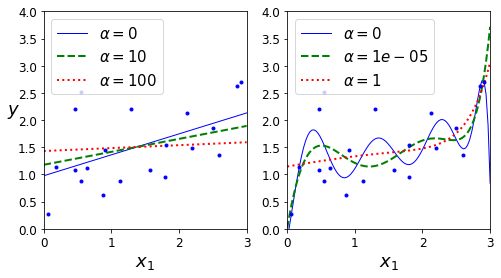

In [38]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

岭回归可视化
- 显示使用不同 alpha 值对某个线性数据进行训练的几种岭回归模型
- 左边直接使用岭回归，导致预测时线性的
- 右边，首先使用 PolynomialFeatures(degree=10) 对数据进行扩展，然后使用 StandardScaler 进行缩放，最后再将岭回归模型用于结果特征
- 右边，就是正则化后的多项式回归，仔细看 alpha 如何使预测更加平坦，降低模型方差，提升偏差
- 与线性回归一样，可以在计算闭式方程或者执行梯度下降时，执行岭回归

![self](./image/ridge2.png)

In [39]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [41]:
# 使用随机梯度下降
# 超参数 penalty="l2" 设置正则化的类型，l2 表示 SGD 在成本函数中添加正则项，等于权重向量的 l2 范数的平方的一半，即岭回归
sgd_reg = SGDRegressor(penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

## 套索回归（Lasso Regression）
- 线性回归的另一种正则化，也称之为 最小绝对收缩和选择算子回归（Least Absolute Shrinkage and Selection Operator Regression, 简称 Lasso回归）
- 与岭回归一样，也是向成本函数添加一个正则项，增加的是权重向量的 l1 范数，而不是 l2 范数的平方的一半
- Lasso 回归重要特点是倾向于完全消除掉最不重要的特征的权重（也即是设置为零）
- Lasso 回归会自动执行特征选择并输出一个稀疏模型，即只要很少特征有非零权重

![self](./image/lasso.png)
![self](./image/lasso2.png)


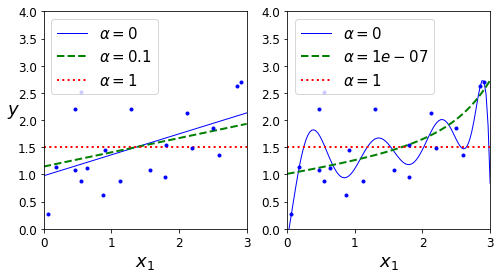

In [42]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

In [43]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## 弹性网络 Elastic Net
- 弹性网络是岭回归和Lasso 回归之间的中间地带
- 其正则项就是岭回归和Lasso 回归正则项的混合，混合比例通过 r 来控制
- 当 r=0，相当于岭回归；当 r=1，相当于Lasso 回归
- 如何选择 线性回归、岭回归、Lasso 回归、弹性网络？
    - 通常来说，有正则项——哪怕很小，总是比没有更加可取，所以大多数情况下，避免使用纯线性回归
    - 岭回归是一个不错的默认选择，但是实际用到的特征只有少数几个，更应该倾向于 Lasso 回归和弹性网络
    - Lasso 回归会将无用特征的权重降为零（自动执行特征选择）
    - 一般而言，弹性网络优于 Lasso 回归，因为特征数量超过训练实例数量，又或者几个特征强相关时，Lasso 回归的表现不稳定
    
![self](./image/net.png)

使用 sklearn 的 ElasticNet 小例子

In [44]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## 早期停止法
- 对于梯度下降这一类迭代算法，还有一个与众不同的正则化方法，就是在验证错误达到最小值时停止训练，该方法称之为早期停止法
- 例如以下代码展现使用批量梯度下降训练复杂模型（高阶多项式回归模型）
- 经过一轮一轮的训练，算法不断学习，训练集上误差自然不断下降，同样在其验证集上的预测误差也随之下降
- 但是一段时间后，验证误差停止下降反而开始回升，这说明模型开始过度拟合训练数据
- 通过早期停止法，一旦验证误差达到最小值就立即停止训练，这是一个非常简单而且有效的正则化技巧


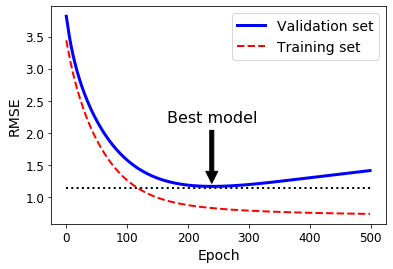

In [54]:
# 警告过滤器
import warnings
# # 警告过滤器用于控制警告的行为，如忽略匹配的警告
warnings.filterwarnings('ignore')

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train_predict, y_train))
    val_errors.append(mean_squared_error(y_val_predict, y_val))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [55]:
# 警告过滤器
import warnings
# # 警告过滤器用于控制警告的行为，如忽略匹配的警告
warnings.filterwarnings('ignore')

# 早期停止法的基本实现
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [56]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=True))

## 三种正则化可视化分析

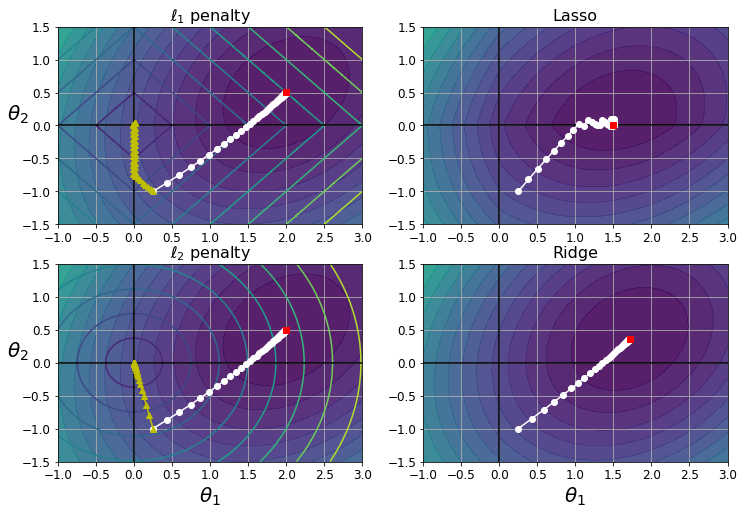

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np



t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])




def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])

for subplot in (221, 223):
    plt.subplot(subplot)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

for subplot in (223, 224):
    plt.subplot(subplot)
    plt.xlabel(r"$\theta_1$", fontsize=20)

plt.show()

# 逻辑回归 Logistic regression
- 也称之为罗吉思回归，广泛用于估算一个实例属于某个特定类比的概率
- 比如，电子邮件属于垃圾邮件的概率有多高，预估概率超过 50% ，则模型预测该邮件实例为垃圾（正类 ，标记 1），反之则预测不是，负类，标记 0
- 这样一个二元分类器


## 概率估算
- 逻辑回归模型也是计算输入特征的加权和加上偏置项
- 不同于线性回归模型直接输出结果，输出的是结果的数理逻辑
- 逻辑模型是一个 sigmoid 函数 S形，输出为一个 0 到 1 之间的数字

![self](./image/logictic.png)
![self](./image/logictic2.png)


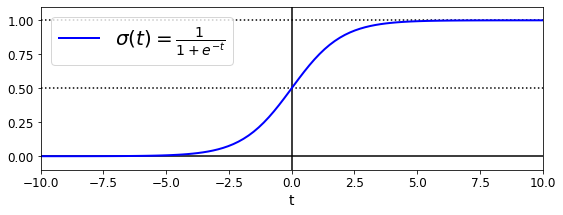

In [59]:
# 可视化 sigmoid 函数

t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

## 训练和成本函数
- 怎么训练 logistics 模型？
- 训练的目的就是设置参数向量 θ ，使得模型对正类实例做出高概率估算，对负类实例做出低概率估算

![self](./image/logistics1.png)
![self](./image/logistics2.png)
![self](./image/logistics3.png)


## 决策边界
- 使用 sklearn 鸢尾花数据集说明逻辑回归，著名数据集
- 共有 150 朵鸢尾花，分别来自三个不同品种：Setosa 鸢尾花，Versicolor 鸢尾花，Virginica 鸢尾花，数据里面包含鸢尾花的萼片以及花瓣的长度和宽度

![self](./image/iris.png)


In [61]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [62]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [63]:
# 仅基于花瓣宽度这个特征，创建一个分类器来检测 Virginica 鸢尾花
# petal width
X = iris["data"][:, 3:]
# 1 if Iris-Virginica, else 0
y = (iris["target"] == 2).astype(np.int)


In [64]:
# 训练逻辑回归模型
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

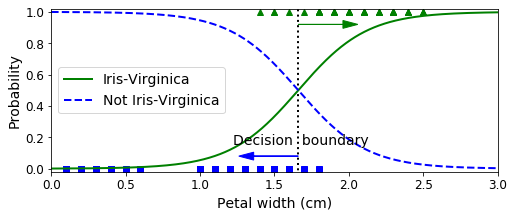

In [65]:
# 可视化
# 看一看花瓣宽度在 0 到 3 厘米之间的鸢尾花，模型估算出来的概率

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

可视化结果显示
- Virginica 鸢尾花 ( 三角形所示 ) 的花瓣宽度范围为 1.4~2.5 厘米
- 而其他两种鸢尾花 ( 正方形所示 ) 花瓣通常较窄，花瓣宽度范围为 0.1~1.8 厘米，注意，这里有一部分重叠
- 对花瓣宽度超过 2cm 的花，分类器可以很有信心地说它是一朵 Virginica 鸢尾花 (对该类别输出一个高概率值)
- 对花瓣宽度低于 1cm 以下的，也可以胸有成竹地说其不是( 对“非Virginica鸢尾花”类别输出一一个高概率值)
- 在这两个极端之间，分类器则不太有把握
- 但是，如果要求它预测出类别(使用 predict() 方法而不是 predict_proba()方法 )，它将返回一个可能性最大的类别
- 也就是说，在大约 1.6 厘米处存在一个决策边界，这里 “是” 和 “不是” 的可能性都是 50%
- 如果花瓣宽度大于 1.6 厘米，分类器就预测它是 Virginica 鸢尾花，否则就预测不是(即使它没什么把握)


In [66]:
# 查看决策边界
decision_boundary

array([1.66066066])

In [68]:
# 查看决策情况
log_reg.predict([[1.7], [1.5]])

array([1, 0])

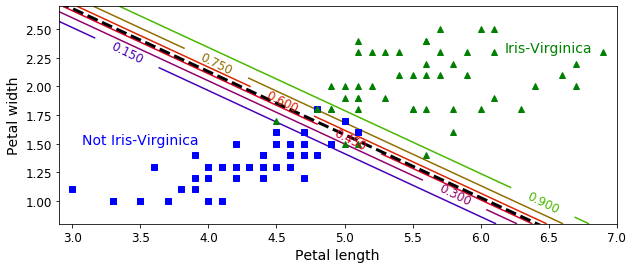

In [69]:
# 同样的数据集，使用两个特征，花瓣宽度和花瓣长度

from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

可视化结果显示
- 同样的数据集，但是这次显示了两个特征: 花瓣宽度和花瓣长度
- 经过训练，这个逻辑回归分类器就可以基于这两个特征来预测新花朵是否属于 Virginica 鸢尾花
- 虚线表示模型估算概率为 50% 的点，即模型的决策边界
- 注意这里是一个线性的边界
- 每条平行线都分别代表一个模型输出的特定概率，从左下的 15% 到右上的 90% 
- 根据这个模型，右上线之上的所有花朵，都有超过 90% 的概率属于 Virginica 鸢尾花
- 逻辑回归模型可以使用 l1 或者 l2 范数进行惩罚函数来正则化，sklearn 默认使用 l2 范数
- 控制 sklearn LogisticRegression 模型正则化程度的超参数不是 alpha（其他线性模型是使用 alpha） 而是它的逆：C，C的值越高，模型正则化程度越高


# Softmax 回归
- 逻辑回归经过推广，可以直接支持多个类别，而不需要训练并组合多个二元分类器
- 这推广称之为 Softmax 回归，或者 多元逻辑回归
- 使用 Softmax 回归将鸢尾花分为三类

![self](./image/iris1.png)
![self](./image/iris2.png)
![self](./image/iris3.png)
![self](./image/iris4.png)

- 既然已经知道了模型如何进行概率估算并做出预测，那看看怎么训练
- 训练目标是得到一个能对目标类别做出高概率估算的模型 (也就是其他类别的概率相应要很低)
- 通过将公式的成本函数 (也叫作交叉熵) 最小化来实现这个目标，因为当模型对目标类别做出较低概率的估算时，会受到惩罚
- 交叉熵经常被用于衡量一组估算出的类别概率跟目标类别的匹配程度

![self](./image/iris5.png)

交叉熵
- 交叉熵源于信息理论
- 假设想要有效传递每天的天气信息，选项(晴、下雨等)有 8 个，那么可以用 3bit 对每个选项进行编码，2^3=8
- 但是，如果认为几乎每天都是晴天，那么，对“晴天”用 1 比特(0)，其他七个类别用 4 比特(从 1 开始)进行编码，显然会更有效率一些
- 交叉熵衡量的是每次发送天气选项的平均比特数
- 如果对天气的假设是完美的，交叉熵将会等于天气本身的熵(也就是其本身固有的不可预测性)
- 但是如果的假设是错误的(比如经常下雨)，交叉熵将会变大，增加的这一部分称之为 KL散度(Kullback-Leibler divergence,也叫作相对熵)
- 两个概率分布 p 和 q 之间的交叉熵定义为 H(p,q) = -sum(p(x)log q(x)) (至少在离散分布时可以这样定义)

![self](./image/iris6.png)

In [70]:
# petal length, petal width
X = iris["data"][:, (2, 3)]
y = iris["target"]

# 训练模型
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

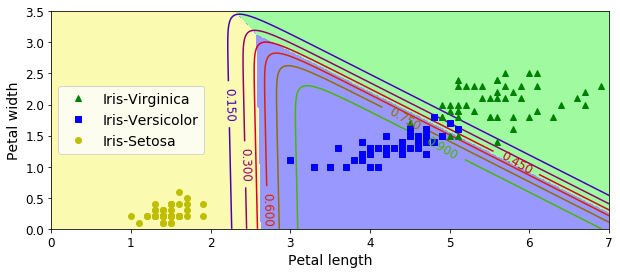

In [71]:
# 可视化这个模型过程，决策边界
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

可视化
- 展现有不同背景表示的决策边界
- 任何两个类别之间的决策边界都是线性的
- 折线表示属于 Versicolor 鸢尾花的概率
- 该模型预测出来的类型，其估算概率有可能低于 50%， 比如，在所有决策边界相交的地方，所有类别的估算概率都是 33%


In [72]:
# 预测 花瓣长 5 厘米， 宽 2 厘米，模型预测种类
softmax_reg.predict([[5, 2]])

array([2])

In [73]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

# 练习 Exercise solutions

1. 如果你的训练集有超过百万个特征，你会选择什么线性回归训练算法?
2. 如果你的训练集里特征的数值大小迥异，什么算法可能会受到影响? 受影响程度如何? 你应该怎么做?
3. 训练逻辑回归模型时， 梯度下降是否会困于局部最小值?
4. 假设运行时间足够长，所有的梯度下降算法是不是最终会产生相同的模型?
5. 假设你使用的是批量梯度下降，并且每一轮训练都绘制出其验证误差，如果发现验证误差持续上升，可能发生了什么? 你如何解决这个问题?
6. 当验证误差开始，上升时，立刻停止小批量梯度下降算法训练是否为一个好主意?
7. 哪种梯度下降算法(所有讨论过的)能最快到达最优解的附近? 哪种会收敛? 如何使其他算法同样收敛?
8. 假设你使用的是多项式回归，绘制出学习曲线，你发现训练误差和验证误差之间存在很大的差距。发生了什么? 哪三种方法可以解决这个问题?
9. 假设你使用的是岭回归，你注意到训练误差和验证误差几乎相等，并且非常高。你认为模型是高方差还是高偏差? 你应该提高还是降低正则化超参数 α ?
10. 你为何要使用:
    - 岭回归而不是线性回归?
    - Lasso 回归而不是岭回归?
    - 弹性网络而不是 Lasso回归?
11. 如果你想将图片分类为户外/室内以及白天/黑夜。你应该实现两个逻辑回归分类器还是一个 Softmax 回归分类器?
12. 用 Softmax回归 进行批量梯度下降训练，并实施早期停止法(不使用Scikit-Learn)


# solution

1. 如果你的训练集有超过百万个特征，你会选择什么线性回归训练算法?

solution：如果训练集有数百万个特征，可以使用随机梯度下降或者是小批量梯度下降，如果内存允许，甚至可以使用批量梯度下降。但是由于计算复杂度随着特征数量的增加而快速提升(比二次方还高)，因此不能使用标准方程的方法。

2. 如果你的训练集里特征的数值大小迥异，什么算法可能会受到影响? 受影响程度如何? 你应该怎么做?

solution：如果训练集的特征数值具有非常迥异的尺寸比例，成本函数将呈现为细长的碗状，这导致梯度下降算法将耗费很长时间来收敛。要解决这个问题，需要在训练模型之前先对数据进行缩放。值得注意的是，使用标准方程法，不经过特征缩放也能正常工作。

3. 训练逻辑回归模型时， 梯度下降是否会困于局部最小值?

solution：训练逻辑回归模型时，梯度下降不会陷入局部最小值，因为它的成本函数是凸函数。

4. 假设运行时间足够长，所有的梯度下降算法是不是最终会产生相同的模型?

solution：如果优化问题是凸的(例 如线性回归或者逻辑回归)，并且学习率也不是太高，那么所有梯度下降算法都可以接近全局最优，最终生成的模型都非常相似。但是，除非逐渐降低学习率，否则随机梯度下降和小批量梯度下降都不会真正收敛。相反，它们会不断在全局最优的附近波动。也就是说，即使运行时间非常长，这些梯度下降算法产生的模型仍然会有轻微不同。

5. 假设你使用的是批量梯度下降，并且每一轮训练都绘制出其验证误差，如果发现验证误差持续上升，可能发生了什么? 你如何解决这个问题?

solution：如果验证误差开始每轮上升，那么可能性之一是学习率太高，算法开始发散所致。如果训练误差也开始上升，那么很显然你需要降低学习率了。但是，如果训练误差没有上升，那么模型很可能过度拟合训练集，应该立刻停止训练。

6. 当验证误差开始，上升时，立刻停止小批量梯度下降算法训练是否为一个好主意?

solution：无论是随机梯度下降还是小批量梯度下降，由于它们的随机性，使得它们都不能保证在每一次的训练迭代中都取得进展。所以，如果在验证误差刚开始上升时就停止训练，很有可能会在达到最优之前过早停止训练。更好的方法是定时保存模型，当较长一段时间都没有改善时(意味着可能不会再超过最好的记录了)，可以恢复到保存的最优模型。

7. 哪种梯度下降算法(所有讨论过的)能最快到达最优解的附近? 哪种会收敛? 如何使其他算法同样收敛?

solution：随机梯度下降的训练迭代最快，因为它- -次只考虑一个训练实例，所以通常来说，它会最快到达全局最优的附近(或者是批量非常小的小批量梯度下降)。但是，只有批量梯度下降才会经过足够长时间的训练后真正收敛。对于随机梯度下降和小批量梯度下降来说，除非逐渐调低学习率，否则将一直围绕最小值上上下下。

8. 假设你使用的是多项式回归，绘制出学习曲线，你发现训练误差和验证误差之间存在很大的差距。发生了什么? 哪三种方法可以解决这个问题?

solution：如果验证误差远高于训练误差，可能是因为模型过度拟合训练集。解决这个问题的方法之一是对多项式降阶:自由度越低的模型，过度拟合的可能性越低。另一个方法是对模型进行正则化一例如， 在成本函数中增加l2 (岭回归)或li (Lasso回归)惩罚，同样可以降低模型的自由度。最后，你还可以尝试扩大训练集。

9. 假设你使用的是岭回归，你注意到训练误差和验证误差几乎相等，并且非常高。你认为模型是高方差还是高偏差? 你应该提高还是降低正则化超参数 α ?

solution：如果训练误差和验证误差相近，并且都非常高，则模型很可能对训练集拟合不足。这意味着偏差较高，应该尝试降低正则化超参数。

10. 你为何要使用:
    - 岭回归而不是线性回归?
    - Lasso 回归而不是岭回归?
    - 弹性网络而不是 Lasso回归?

solution：
- 有正则化的模型通常比没有正则化的模型表现得更好，所以应该优先选择岭回归而不是普通的线性回归。
- Lasso 回归使用 l1 惩罚函数，往往倾向于将不重要的特征权重降至零。这将生成一个除了最重要的权重之外，其他所有权重都为零的稀疏模型。这是自动执
行特征选择的一种方法，如果你觉得只有少数几个特征是真正重要的，这不失为一个非常好的选择，但是当您不确定的时候，应该更青睐岭回归模型。
- 弹性网络比 Lasso更受欢迎，因为某些情况下Lasso可能产生异常表现(例如当多个特征强相关，或者特征数量比训练实例多时)。并且，弹性网络会添加一个额外的超参数来对模型进行调整。如果你想使用Lasso，只需要将弹性网络的 11_ ratio 设置为接近 1 即可。

11. 如果你想将图片分类为户外/室内以及白天/黑夜。你应该实现两个逻辑回归分类器还是一个 Softmax 回归分类器?

solution：要将图片分类为户外/室内和白天/夜间，你应该训练两个逻辑回归分类器，因为这些类别之间并不是排他的(存 在四种组合)。

12. 用 Softmax回归 进行批量梯度下降训练，并实施早期停止法(不使用Scikit-Learn)

solution:

## 12. Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn)

In [74]:
# Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.
# petal length, petal width
X = iris["data"][:, (2, 3)]  
y = iris["target"]

In [75]:
# We need to add the bias term for every instance ($x_0 = 1$):
X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [76]:
# And let's set the random seed so the output of this exercise solution is reproducible:
np.random.seed(2042)

In [77]:
# The easiest option to split the dataset into a training set, a validation set and a test set 
# would be to use Scikit-Learn's `train_test_split()` function, 
# but the point of this exercise is to try understand the algorithms by implementing them manually. 
# So here is one possible implementation:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

In [78]:
# The targets are currently class indices (0, 1 or 2), 
# but we need target class probabilities to train the Softmax Regression model. 
# Each instance will have target class probabilities equal to 0.0 for all classes 
# except for the target class which will have a probability of 1.0 
# (in other words, the vector of class probabilities for ay given instance is a one-hot vector). 
# Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [79]:
# Let's test this function on the first 10 instances:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [80]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [81]:
# Looks good, so let's create the target class probabilities matrix for the training set and the test set:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [82]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [83]:
# We are almost ready to start training. 
# Let's define the number of inputs and outputs:

# == 3 (2 features plus the bias term)
n_inputs = X_train.shape[1] 

# == 3 (3 iris classes)
n_outputs = len(np.unique(y_train))   

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [84]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693313
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.44824244188957774
4000 0.4278651093928792
4500 0.41060071429187134
5000 0.3956780375390373


In [85]:
# And that's it! The Softmax model is trained. 
# Let's look at the model parameters:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

In [86]:
# Let's make predictions for the validation set and check the accuracy score:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [87]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629506
1000 0.503640075014894
1500 0.49468910594603216
2000 0.4912968418075477
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.489035124439786
4000 0.4889173621830817
4500 0.4888643337449303
5000 0.4888403120738819


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [88]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

In [89]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580262
2000 0.5331959249285545
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327975 early stopping!


In [90]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Still perfect, but faster.

Now let's plot the model's predictions on the whole dataset:

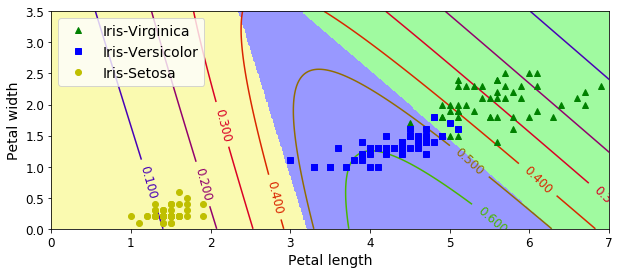

In [91]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [92]:
# And now let's measure the final model's accuracy on the test set:

logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.